<a href="https://colab.research.google.com/github/damenija7/onlab/blob/main/onlab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 !pip install numpy pandas networkx tqdm cython line_profiler &> /dev/null
 !pip install scipy pgmpy &> /dev/null

import numpy as np
import networkx as nx
import pandas as pd
from collections import Counter




## Segédfüggvény: Szomszédsági mátrix körmentesség vizsgálat (Kahn algoritmusa)

In [ ]:
%load_ext Cython

In [ ]:
%%cython --annotate --cplus -I numpy.get_include()

cimport numpy as np
cimport cython
from libcpp cimport bool
from libcpp.vector cimport vector
from libcpp.queue cimport queue

@cython.boundscheck(False)
@cython.wraparound(False)
def isGraphAcyclic(np.uint8_t[:,::1] incidenceMatrix, int numNodes):
  cdef queue[int] nodesToVisit
  cdef vector[int] inDegrees = vector[int](numNodes, 0)
  cdef int nodesNotInCycle = 0
  cdef int i, j, currentNodeIdx

  for i in range(numNodes):
    for j in range(numNodes):
      inDegrees[j] += incidenceMatrix[i, j]

  # Kezdetleges "gyökerek" megtalálása
  for i in range(numNodes):
    if (inDegrees[i] == 0):
      nodesToVisit.push(i)

  while not nodesToVisit.empty():
    currentNodeIdx = nodesToVisit.front()
    nodesToVisit.pop()
    nodesNotInCycle += 1
    for i in range(numNodes):
      if (incidenceMatrix[currentNodeIdx, i] != 0):
        inDegrees[i] -= 1
        if (inDegrees[i] == 0):
          nodesToVisit.push(i)

  return nodesNotInCycle == numNodes


## Segédosztály:  Adott adatkeret alapján, adott szomszédsági mátrix alapján gráf / csúcs bic/bdeu score-ját számítja, dict alapú cache-el

In [ ]:
from math import lgamma, log, factorial, log, exp
  
class Scorer_BDeu(object):
  ##
  # variableArities == 1 -> dataFrame első rekordja tartalmazza az aritásokat
  ##
  def __init__(self, dataFrame, variableArities = None, N_prime = 1.0):
    if (variableArities is None):
      # ekkor 1. sor tartalmazza az aritásokat
      self.dataFrame = dataFrame[1:]
      self.variableArities = [int(x) for x in dataFrame.iloc[0]]
    else:
      self.dataFrame = dataFrame
      self.variableArities = variableArities

    self.numVariables = self.dataFrame.shape[1]
    self.variableNames = np.array(self.dataFrame.columns.values)
    
    self.N = self.dataFrame.shape[0]
    self.N_prime = N_prime
    
    self.cache = {}


  def collectVariableValues(self, variableIdx):
    return tuple(sorted(self.dataFrame.iloc[:, variableIdx].dropna().unique()))

  
  def updateCache(self, groupIndices):
    N_ijk_map = Counter()
    self.cache[groupIndices] = N_ijk_map

    groupBy = list(self.variableNames[list(groupIndices)])

    configurationOccurences = self.dataFrame.groupby(by = groupBy, sort = False).size()

    for config, occurences in configurationOccurences.iteritems():
      N_ijk_map[config] = occurences


  # http://www.lx.it.pt/~asmc/pub/talks/09-TA/ta_pres.pdf
  # 19. oldal 
  # ---------
  # parentIndices [idx1,...,idxk] szülőkkel rendelkező varIdx indexű csúcsra számol BDeuScore-t
  # ---------
  def localScore(self, varIdx, parentIndices):
    score = 0.0

    groupByIndices = tuple(list(parentIndices) + [varIdx])
    
    N_ijk_map = self.cache.get(groupByIndices)
    ##
    # NINCS CACHELVE MÉG
    ## 
    if N_ijk_map is None:
      self.updateCache(groupByIndices)
    N_ijk_map = self.cache.get(groupByIndices)

    N_prime__over__q_i = self.N_prime
    for parentIdx in range(len(parentIndices)):
      N_prime__over__q_i /= self.variableArities[parentIdx]

    N_prime__over__q_i_r_i = N_prime__over__q_i / self.variableArities[varIdx]

    # Nincs szulo, ekkor nem lehet ijk, N_ijk modon iteralni configurationOccurences-en
    if len(parentIndices) == 0:
      N_ij = 0
      for config in N_ijk_map:
        N_ijk = N_ijk_map[config]
        N_ij += N_ijk
        score += lgamma(N_ijk + N_prime__over__q_i_r_i) - lgamma(N_prime__over__q_i_r_i)
      score += lgamma(N_prime__over__q_i) - lgamma(N_prime__over__q_i + N_ij)  
    else:        
      N_ij_map = Counter()

      for config in N_ijk_map:
        N_ijk = N_ijk_map[config]
        N_ij_map[config[:-1]] += N_ijk
        score += lgamma(N_ijk + N_prime__over__q_i_r_i) - lgamma(N_prime__over__q_i_r_i)
      
      for N_ij in N_ij_map.values():
        score += lgamma(N_prime__over__q_i) - lgamma(N_prime__over__q_i + N_ij)  


    return score

  def Score(self, ancestryOrIncidenceMatrix, usingAncestryMatrix = False):
    wholeScore = 0.0

    if not usingAncestryMatrix:
      ancestryOrIncidenceMatrix = ancestryOrIncidenceMatrix.transpose()

    parentIndicesForVars = [np.flatnonzero(ancestryOrIncidenceMatrix[rowIdx]) for rowIdx  in range(self.numVariables)]
    for varIdx in range(self.numVariables):
      wholeScore += self.localScore(varIdx, parentIndicesForVars[varIdx])
    return wholeScore


  def ScoreByNodes(self, ancestryOrIncidenceMatrix, usingAncestryMatrix = False):
    # float64
    scores = np.zeros(self.numVariables)

    if not usingAncestryMatrix:
      ancestryOrIncidenceMatrix = ancestryOrIncidenceMatrix.transpose()

    parentIndicesForVars = [np.flatnonzero(ancestryOrIncidenceMatrix[rowIdx]) for rowIdx  in range(self.numVariables)]
    for varIdx in range(self.numVariables):
      scores[varIdx] = self.localScore(varIdx, parentIndicesForVars[varIdx])
    return scores
    


In [ ]:
from math import lgamma, log, factorial, log, exp
import numpy as np
    
class Scorer_BIC(object):
  ##
  # variableArities == 1 -> dataFrame első rekordja tartalmazza az aritásokat
  ##
  def __init__(self, dataFrame, variableArities = None):
    if (variableArities is None):
      # ekkor 1. sor tartalmazza az aritásokat
      self.dataFrame = dataFrame[1:]
      self.variableArities = [int(x) for x in dataFrame.iloc[0]]
    else:
      self.dataFrame = dataFrame
      self.variableArities = variableArities


    self.numVariables = self.dataFrame.shape[1]
    self.variableNames = np.array(self.dataFrame.columns.values)
    self.N = self.dataFrame.shape[0]
    self.cache = {}


  def collectVariableValues(self, variableIdx):
    return tuple(sorted(self.dataFrame.iloc[:, variableIdx].dropna().unique()))

  def updateCache(self, groupIndices):
    N_ijk_map = Counter()
    self.cache[groupIndices] = N_ijk_map

    groupBy = list(self.variableNames[list(groupIndices)])

    configurationOccurences = self.dataFrame.groupby(by = groupBy, sort = False).size()

    for config, occurences in configurationOccurences.iteritems():
      N_ijk_map[config] = occurences

  # http://www.lx.it.pt/~asmc/pub/talks/09-TA/ta_pres.pdf
  # 25. oldal 
  # ---------
  # parentIndices [idx1,...,idxk] szülőkkel rendelkező varIdx indexű csúcsra számol BICScore-t
  # ---------
  def localScore(self, varIdx, parentIndices):
    score = 0.0

    groupByIndices = tuple(list(parentIndices) + [varIdx])


    N_ijk_map = self.cache.get(groupByIndices)
    ##
    # NINCS CACHELVE MÉG
    ## 
    if N_ijk_map is None:
      self.updateCache(groupByIndices)
    N_ijk_map = self.cache.get(groupByIndices)

    penalty = self.variableArities[varIdx] -1

    ## VAN SZÜLŐ
    if len(parentIndices) != 0:
      N_ij_map = Counter()
      for config in N_ijk_map:
        N_ijk = N_ijk_map[config]
        N_ij_map[config[:-1]] += N_ijk
      for config in N_ijk_map:
        N_ijk = N_ijk_map[config]
        score += N_ijk * np.log(N_ijk / N_ij_map[config[:-1]])
      for parentIndex in parentIndices:
        penalty *= self.variableArities[parentIndex]
    # NINCS SZÜLŐ
    else:
      N_ij = 0
      for config in N_ijk_map:
        N_ijk = N_ijk_map[config]
        N_ij += N_ijk
      for config in N_ijk_map:
        N_ijk = N_ijk_map[config]
        score += N_ijk * np.log(N_ijk / N_ij)
   

    penalty *= 1/2 * np.log(self.N)
    return score - penalty

  def Score(self, ancestryOrIncidenceMatrix, usingAncestryMatrix = False):
    wholeScore = 0.0

    if not usingAncestryMatrix:
      ancestryOrIncidenceMatrix = ancestryOrIncidenceMatrix.transpose()

    parentIndicesForVars = [np.flatnonzero(ancestryOrIncidenceMatrix[rowIdx]) for rowIdx  in range(self.numVariables)]
    for varIdx in range(self.numVariables):
      wholeScore += self.localScore(varIdx, parentIndicesForVars[varIdx])
    return wholeScore


  def ScoreByNodes(self, ancestryOrIncidenceMatrix, usingAncestryMatrix = False):
    # float64
    scores = np.zeros(self.numVariables)

    if not usingAncestryMatrix:
      ancestryOrIncidenceMatrix = ancestryOrIncidenceMatrix.transpose()

    parentIndicesForVars = [np.flatnonzero(ancestryOrIncidenceMatrix[rowIdx]) for rowIdx  in range(self.numVariables)]
    for varIdx in range(self.numVariables):
      scores[varIdx] = self.localScore(varIdx, parentIndicesForVars[varIdx])
    return  scores
    


## Segédfüggvény: Adott szomszédsági mátrixra, maximális megengedett szülő szám mellett megadja a lehetséges edge remove / add / reverse jelölteket, valamint az ilyen összes jelölt számát

In [ ]:
def get_NumberOfNeighbors_EdgeAddCandidates_EdgeRemoveReverseCandidates(incidenceMatrix, pathMatrix, numNodes, maxNumParents):
  # bejövő élek száma ne legyen maxNumParents vagy annál nagyobbű
  # (oszloponként összegezve kapjuk az egyes csúcsókra a bejövő élek számát)
  parentLimitNotReached = (incidenceMatrix.sum(axis=0) < maxNumParents)


  #-------
  # edge add
  #-------

  # Amikor a, b csúcs között nincs él (a sor, b oszlop és b oszlop, a sor üres), akkor lehetséges szomszéd, ahol (a,b) vagy (b,a) él adódik -> Hozzáadjuk a transzponáltat
  # Egység mátrixot (np.identity) azért adjuk hozzá, mert a->a hurokéleket biztosan kizárjuk.
  edgeAddCandidates = ((incidenceMatrix + incidenceMatrix.transpose()  + np.identity(numNodes, dtype = np.int8)) < 1)


  ## ha (j,i) >= 1, akkor van már j->i út, ergó i->j beillesztése után lesz j->i->j kör
  addingEdgeWouldNotIntroduceCycle = pathMatrix.transpose() == 0
  edgeAddCandidates &= addingEdgeWouldNotIntroduceCycle

  
  # Ekkor (a, b) akkor és csak akkor igaz candidate, ha nincs köztük él és  b-nek nincs túl sok szüleje
  edgeAddCandidates &= parentLimitNotReached
  numEdgeAddNeighbors = edgeAddCandidates.sum()


  #-------
  # edge remove
  #-------

  
  # Annyi él van jelenleg, amennyi 1-es elem van a mátrixban
  edgeRemoveCandidates = incidenceMatrix >= 1
  numEdgeRemoveNeighbors = edgeRemoveCandidates.sum()


  #-------
  # edge reverse
  #-------


  # (i,j) reverse: Létezik (i, j) úton kívül más i->j út esetén kör lesz
  # -> legyen legfeljebb 1 db i->j út, ami biztosan (i, j)
  reversingEdgeWouldNotIntroduceCycle = pathMatrix <= 1

  # (a, b) fordítása akkor és csak akkor igaz candidate, ha meg van az él, és a-nak nincs túl sok szüleje (parentLimitNotReached transpose), és nem keletkezik kör
  edgeReverseCandidates = (edgeRemoveCandidates & parentLimitNotReached.reshape(numNodes,1))
  edgeReverseCandidates &= reversingEdgeWouldNotIntroduceCycle

  numEdgeReverseNeighbors = edgeReverseCandidates.sum()
  

  #numNeighbors = numEdgeAddNeighbors + numEdgeRemoveNeighbors + numEdgeReverseNeighbors


  # Ha üres a gráf
  if numEdgeRemoveNeighbors == 0:
    edgeRemoveCandidates = None
  # Ha minden (a,b) élre a elérte a max szülő számot
  if numEdgeReverseNeighbors == 0:
    edgeReverseCandidates = None
  # Ha nem lehet élet hozzáadni a gráfhoz
  if numEdgeAddNeighbors == 0:
    edgeAddCandidates = None


  return (numEdgeAddNeighbors, numEdgeRemoveNeighbors, numEdgeReverseNeighbors), edgeAddCandidates, edgeRemoveCandidates, edgeReverseCandidates

## Segédfüggvény: út mátrix frissítés (aciklikusság biztosításánal használt)

In [ ]:
def updatePathMatrix(newPathMatrix, i, j, stepEnum):
  # él hozzáadás
  if stepEnum == 0:
    ###
    newPathMatrix[i, j] += 1
    # i örökli j útait egyszeres szórzóval
    newPathMatrix[i] += newPathMatrix[j]
    # Akinek i-be van útja, az annyiszor örökli j útait, ahány útja van i-be.
    hasPathTo_i = newPathMatrix[:, i] > 0

    if (hasPathTo_i.any()):
      # + j-be új út ahányszor van út i-ba (X ... i, j)
      newPathMatrix[hasPathTo_i, j] += newPathMatrix[hasPathTo_i, i]
      # j útainak nyerése ahányszor van út i-ba (X, ..., i, j, ..)
      #                             (Y, 1) * (1, numNodes) numpy broadcasting
      newPathMatrix[hasPathTo_i] += np.expand_dims(newPathMatrix[hasPathTo_i, i], 1) * np.expand_dims(newPathMatrix[j], 0)
    ### 
    ### path matrix frissítés vége

  # él eltávolítás
  elif stepEnum == 1:
    hasPathTo_i = newPathMatrix[:, i] > 0
    if (hasPathTo_i.any()):
      newPathMatrix[hasPathTo_i] -= np.expand_dims(newPathMatrix[hasPathTo_i, i], 1) * np.expand_dims(newPathMatrix[j], 0)
      newPathMatrix[hasPathTo_i, j] -= newPathMatrix[hasPathTo_i, i]
    newPathMatrix[i] -= newPathMatrix[j]
    newPathMatrix[i, j] -= 1

  # él fordítás
  else:
    hasPathTo_i = newPathMatrix[:, i] > 0
    if (hasPathTo_i.any()):
      newPathMatrix[hasPathTo_i] -= np.expand_dims(newPathMatrix[hasPathTo_i, i], 1) * np.expand_dims(newPathMatrix[j], 0)
      newPathMatrix[hasPathTo_i, j] -= newPathMatrix[hasPathTo_i, i]
    newPathMatrix[i] -= newPathMatrix[j]
    newPathMatrix[i, j] -= 1

    
    newPathMatrix[j, i] += 1
    newPathMatrix[j] += newPathMatrix[i]
    hasPathTo_j = newPathMatrix[:, j] > 0
    if (hasPathTo_j.any()):
      newPathMatrix[hasPathTo_j, i] += newPathMatrix[hasPathTo_j, j]
      newPathMatrix[hasPathTo_j] += np.expand_dims(newPathMatrix[hasPathTo_j, j], 1) * np.expand_dims(newPathMatrix[i], 0)


## adott láncra mcmc mozgatási lépés
## eredmény: lépés utáni szomszédsági mátrix, csomópontonkénti score

In [ ]:
import numpy as np

def structureMCMC_wanderChain(incidenceMatrix, currentPathMatrix, numNodes, maxNumParents, temperature,  currentStateScoreByNodes, scorer):
  rng = np.random.default_rng()

  (numEdgeAddNeighbors, numEdgeRemoveNeighbors, numEdgeReverseNeighbors), edgeAddCandidates, edgeRemoveCandidates, edgeReverseCandidates = get_NumberOfNeighbors_EdgeAddCandidates_EdgeRemoveReverseCandidates(incidenceMatrix, currentPathMatrix, numNodes,  maxNumParents)
  numNeighbors = numEdgeAddNeighbors + numEdgeRemoveNeighbors + numEdgeReverseNeighbors

  # 0 -> él hozzáadás, 1 -> él eltávolítás, 2 -> él fordítás
  # ha nincs
  moveSteps = []
  moveProbs = []
  if edgeAddCandidates is not None:
    moveSteps.append(0)
    moveProbs.append(numEdgeAddNeighbors)
  if edgeRemoveCandidates is not None:
    moveSteps.append(1)
    moveProbs.append(numEdgeRemoveNeighbors)
  if edgeReverseCandidates is not None:
    moveSteps.append(2)
    moveProbs.append(numEdgeReverseNeighbors)
  

  if (len(moveSteps) == 0):
    print(f"Failed to move chain ! (Couldn't do edge add or edge remove or edge reverse")
    return incidenceMatrix, currentPathMatrix, currentStateScoreByNodes, False

  # Nem csinálunk semmit
  moveSteps.append(3)
  moveProbs.append(1)

  # valoszinuseg normalizálás
  moveProbsSum = sum(moveProbs)
  moveProbs = [x / moveProbsSum for x in moveProbs]

 


  moveStep = rng.choice(a=moveSteps, p = moveProbs)

  newIncidenceMatrix = np.copy(incidenceMatrix)
  newPathMatrix = np.copy(currentPathMatrix)

  # él hozzáadás
  if moveStep == 0:

    edgeAddCandidates = np.flatnonzero(edgeAddCandidates)
    edgeAddChoice = rng.choice(edgeAddCandidates)
  
    i = edgeAddChoice // numNodes
    j = edgeAddChoice % numNodes
    
    newIncidenceMatrix[i, j] = 1
    updatePathMatrix(newPathMatrix, i, j, 0)
    parentAffectedNodes = [j]

  # él eltávolítás
  elif moveStep == 1:
    edgeRemoveCandidates = np.flatnonzero(edgeRemoveCandidates)
    edgeRemoveChoice = rng.choice(edgeRemoveCandidates)

    i = edgeRemoveChoice // numNodes
    j = edgeRemoveChoice % numNodes
    newIncidenceMatrix[i, j] = 0
    updatePathMatrix(newPathMatrix, i, j, 1)
    parentAffectedNodes = [j]


  # él fordítás
  elif moveStep == 2:
    edgeReverseCandidates = np.flatnonzero(edgeReverseCandidates)
    edgeReverseChoice = rng.choice(edgeReverseCandidates)
    i = edgeReverseChoice // numNodes
    j = edgeReverseChoice % numNodes
    newIncidenceMatrix[i, j] = 0
    newIncidenceMatrix[j, i] = 1
    updatePathMatrix(newPathMatrix, i, j, 2)
    parentAffectedNodes = [i, j]
    # semmit tevés
  else:
    return incidenceMatrix, currentPathMatrix, currentStateScoreByNodes, False


  '''
  if not isGraphAcyclic(newIncidenceMatrix, numNodes):
      print(newIncidenceMatrix)
      raise Exception("GRAPH IS NOT ACYCLIC")
  '''

  newStateScoreByNodes = np.copy(currentStateScoreByNodes)
  for parentAffectedNodeIdx in parentAffectedNodes:
    newStateScoreByNodes[parentAffectedNodeIdx] = scorer.localScore(parentAffectedNodeIdx, np.flatnonzero(newIncidenceMatrix[:,parentAffectedNodeIdx]))
    

  (newNumEdgeAddNeighbors, newNumEdgeRemoveNeighbors, newNumEdgeReverseNeighbors), _, _, _ = get_NumberOfNeighbors_EdgeAddCandidates_EdgeRemoveReverseCandidates(newIncidenceMatrix, newPathMatrix, numNodes,  maxNumParents)
  newNumNeighbors = newNumEdgeAddNeighbors + newNumEdgeRemoveNeighbors + newNumEdgeReverseNeighbors
  newStateScore = newStateScoreByNodes.sum()
  currentStateScore = currentStateScoreByNodes.sum()

  #acceptProb = (numNeighbors / newNumNeighbors) * exp(newStateScore - currentStateScore)
  #acceptLogProb = min(0.0, np.log(numNeighbors/newNumNeighbors) + newStateScore - currentStateScore)
  acceptLogProb = min(0.0, np.log(numNeighbors/newNumNeighbors) + temperature * (newStateScore - currentStateScore))
  drawnVal = rng.uniform()

  #if (acceptProb ** temperature >= drawnVal):
  #if acceptLogProb * temperature >= np.log(max(1e-12, drawnVal)):
  if acceptLogProb >= np.log(max(1e-12, drawnVal)):
    return newIncidenceMatrix, newPathMatrix, newStateScoreByNodes, True

  return incidenceMatrix, currentPathMatrix, currentStateScoreByNodes, False

## Főfüggvény MC^3

In [ ]:

from tqdm import tqdm

def structureMCMC(dataFrame, numChains, numIterations, maxNumParents, startingIncidenceMatrices, startingPathMatrices, chainTemps = None, delta_T = 1, scorerType = 'BDeu', variableArities = None, BDeuNPrime = 1.0):
  rng = np.random.default_rng()

  numNodes = len(dataFrame.columns)

  if scorerType == 'BDeu':
    scorer = Scorer_BDeu(dataFrame, variableArities, BDeuNPrime)
  elif scorerType == 'BIC':
    scorer = Scorer_BIC(dataFrame, variableArities)
  else:
    raise Exception("scorerType must be of 'BDeu' or 'BIC'")

  dags = np.zeros((numIterations, numChains, numNodes, numNodes), dtype =  np.uint8)
  dags[0,:] = startingIncidenceMatrices

  dagScores = np.zeros((numIterations, numChains))
  previousScoreByNode = np.zeros((numChains, numNodes), dtype=np.float64)
  for i in range(numChains):
    previousScoreByNode[i] = scorer.ScoreByNodes(startingIncidenceMatrices[i])
    dagScores[0, i] = previousScoreByNode[i].sum()

  previousPathMatrices = startingPathMatrices

  #
  # LOG
  #
  edgeOccurencesByChain = np.zeros((numChains, numNodes, numNodes), dtype = np.uint)
  acceptanceRateByChain = np.zeros(numChains, dtype=np.float64)
  tempSwapRate = 0
  #
  #
  #

  # Beta_i = 1/ (1 + i * deltaT)
  if chainTemps is None:
    chainTemps = np.arange(numChains)
    chainTemps = 1/(1 +  chainTemps * delta_T)

  # random szám generálásra (temp swap)
  tempIndices = np.arange(numChains)


  for iter_i in tqdm(range(1, numIterations)):

    for chain_i in range(numChains):
      #dag, pathMat, scoreByNodes = chainAsyncResults[chain_i].get()
      dag, pathMat, scoreByNodes, dagAccepted = structureMCMC_wanderChain(dags[iter_i-1, chain_i] ,previousPathMatrices[chain_i], numNodes, maxNumParents, chainTemps[chain_i], previousScoreByNode[chain_i], scorer)
      dags[iter_i, chain_i] = dag
      if dagAccepted:
        acceptanceRateByChain[chain_i] += 1
      edgeOccurencesByChain[chain_i] += dag
      previousPathMatrices[chain_i] = pathMat
      previousScoreByNode[chain_i] = scoreByNodes
      dagScores[iter_i, chain_i] = scoreByNodes.sum()
      


    if numChains > 1:
      # Hőmérséklet csere
      # http://bamm-project.org/mc3.html
      # https://www.lancaster.ac.uk/stor-i-student-sites/matthew-darlington/2020/01/17/mcmcmc/
      tempSwapCandidates = rng.choice(tempIndices, 2, replace = False)
      tempSwapChance = rng.random()
      

      #
      temp0Idx = tempSwapCandidates[0]
      temp1Idx = tempSwapCandidates[1]
      temp0Score = previousScoreByNode[temp0Idx].sum()
      temp1Score = previousScoreByNode[temp1Idx].sum()
      temp0 = chainTemps[temp0Idx]
      temp1 = chainTemps[temp1Idx]

      logProb = min(0, (temp0 - temp1)*(temp1Score - temp0Score))
      
      if (np.log(max(1e-12, tempSwapChance)) < logProb): 
        tempSwapRate += 1

        tempSwapCandidates = rng.choice(tempIndices, 2, replace = False)
        #print(f"Swapping between chain {tempSwapCandidates[0]}. and chain {tempSwapCandidates[1]}.")
        tmp = chainTemps[tempSwapCandidates[0]]
        chainTemps[tempSwapCandidates[0]] = chainTemps[tempSwapCandidates[1]]
        chainTemps[tempSwapCandidates[1]] = tmp
    
  

  tempSwapRate /= (numIterations)
  acceptanceRateByChain /= numIterations

  return {
      "dags_ByChain" : dags,
      "dagScores_ByChain":dagScores, 
      "edgeOccurences_ByChain":edgeOccurencesByChain,
      "chainSwapRate" : tempSwapRate,
      "dagAcceptanceRate_ByChain" : acceptanceRateByChain
      }

## Segédfüggvény: Szomszédsági mátrix kirajzolása gráfként labels-beli címkékkel.

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pydot
from IPython.display import Image

def showDag(dag, labels):
  dag = nx.from_numpy_array(dag, create_using=nx.DiGraph)

  labelMapping = {}
  for i in range(len(labels)):
    labelMapping[i] = labels[i]

  dag = nx.relabel_nodes(dag, labelMapping)

  dag = nx.drawing.nx_pydot.to_pydot(dag)

  im = Image(dag.create_png())
  display(im)

10 1 1


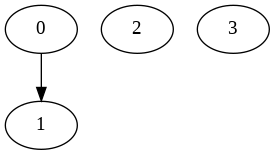

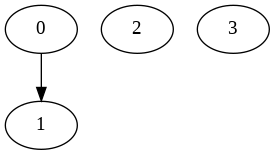

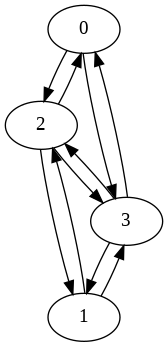

7 2 2


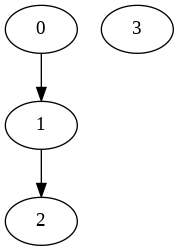

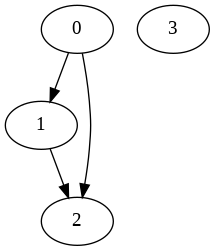

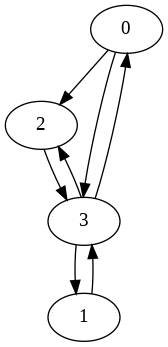

6 3 2


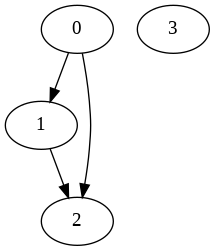

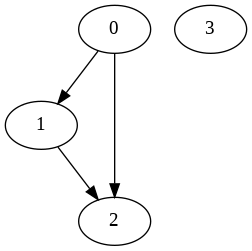

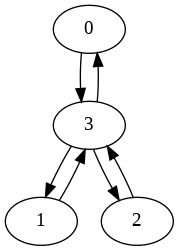

In [ ]:
test = np.zeros((4,4), dtype=np.uint8)
testPath = np.zeros((4,4), dtype=np.uint)

for step in [(0,1), (1,2), (0,2)]:
  test[step] = 1
  updatePathMatrix(testPath, *step, 0)
  (numEdgeAddNeighbors, numEdgeRemoveNeighbors, numEdgeReverseNeighbors), edgeAddCandidates, edgeRemoveCandidates, edgeReverseCandidate = get_NumberOfNeighbors_EdgeAddCandidates_EdgeRemoveReverseCandidates(test, testPath, 4, 3)
  print(numEdgeAddNeighbors, numEdgeRemoveNeighbors, numEdgeReverseNeighbors)
  showDag(test, ["0",'1','2','3'])
  showDag(testPath, ['0','1','2','3'])
  showDag(edgeAddCandidates, ['0','1','2','3'])
  

## dataFrame szerzés (melynél nincs szükség diszkretizációra)

## A választás: https://www.bnlearn.com/documentation/man/asia.html

## Megjegyzés: olyan dataframe-et használnuk, ahol az első sor tartalmazza az aritásokat

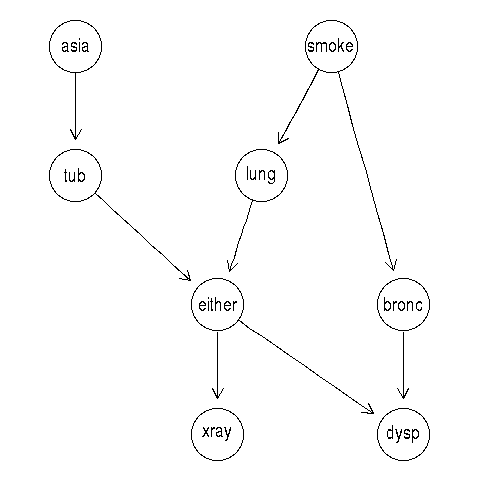



In [ ]:
!wget https://raw.githubusercontent.com/damenija7/onlab/main/asia.csv -O asia.csv &> /dev/null
dFrameName = 'asia.csv'
import pandas as pd


dataFrame = pd.read_csv(dFrameName)
# 1., rekord indexeket tartalmazó oszlop dobása
dataFrame = dataFrame.drop(dataFrame.columns[0], 1)

variableArities = [2 for X in range(len(dataFrame.columns.values))]


labels = dataFrame.columns.values
print(labels)

['A' 'S' 'T' 'L' 'B' 'E' 'X' 'D']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


## Teszteljük, hogy:
  1.  Helyes Score-ok a fönt látott baseline dag-ra
  2.  Path Matrix helyesen működik különböző műveletek után a gráfon

## Elvárt score értékek a minta struktúrára (R bnlearn alapján):
## Használt script: https://github.com/damenija7/onlab/blob/main/scoreCheck.R
  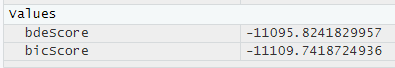

BDeu Score: -11095.824182995622
BIC Score: -11109.741872493603






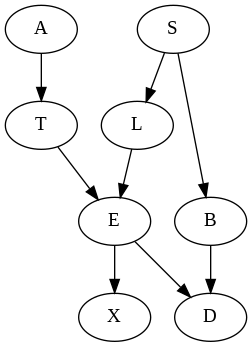

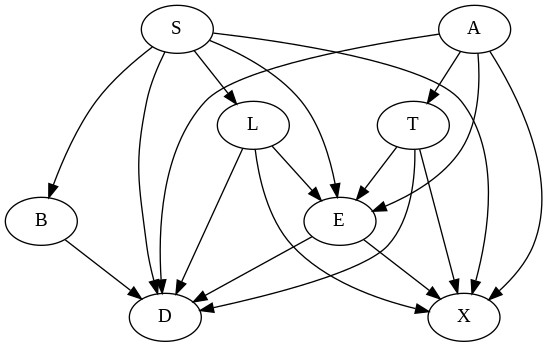

removing "A"->"X"
removing "B"->"L"


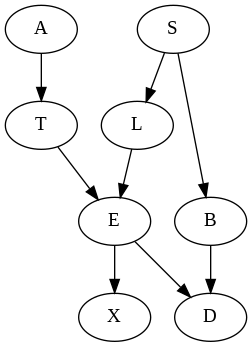

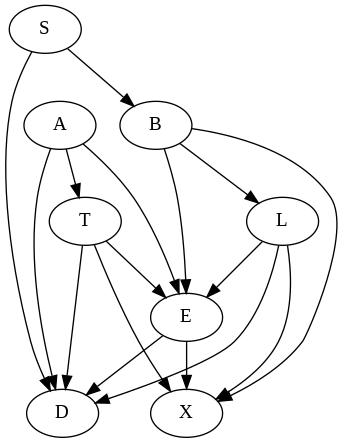

reversing "S"->"T"


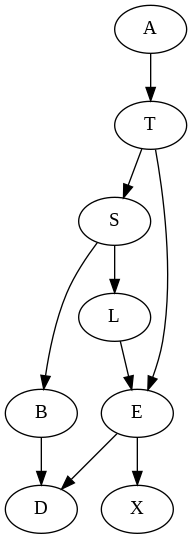

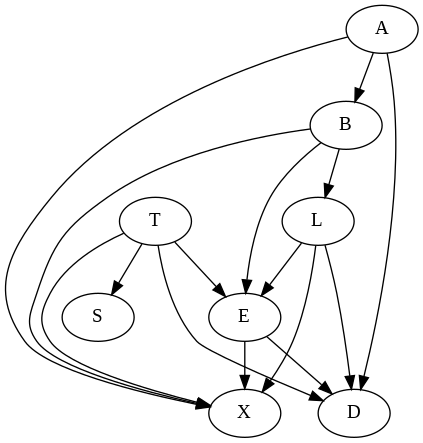

In [ ]:
referenceDag = np.zeros((8,8), dtype = np.uint8)
referenceDagPathMatrix = np.zeros((8,8), dtype = np.uint)

EdgeList = [("A","T"),("S","L"),("T","E"),("L","E"),("S","B"),("E","X"),("E","D"),("B","D")]

variableNameToIndex = {
    'A' : 0,
    'S' : 1,
    'T' : 2,
    'L' : 3,
    'B' : 4,
    'E' : 5,
    'X' : 6,
    'D' : 7
}



for addStep in EdgeList:
  addStep = (variableNameToIndex[addStep[0]], variableNameToIndex[addStep[1]])

  referenceDag[addStep] = 1
  updatePathMatrix(referenceDagPathMatrix, addStep[0], addStep[1], 0)


scorerBIC = Scorer_BIC(dataFrame, variableArities)
scorerBDeu = Scorer_BDeu(dataFrame, variableArities, N_prime = 1.0)

referenceScoreBIC = scorerBIC.Score(referenceDag)
referenceScoreBDeu = scorerBDeu.Score(referenceDag)

(numEdgeAddNeighbors, numEdgeRemoveNeighbors, numEdgeReverseNeighbors), edgeAddCandidates, edgeRemoveCandidates, edgeReverseCandidate = get_NumberOfNeighbors_EdgeAddCandidates_EdgeRemoveReverseCandidates(referenceDag, referenceDagPathMatrix, 8, 6)


print(f'BDeu Score: {referenceScoreBDeu}\nBIC Score: {referenceScoreBIC}\n')
print('\n\n')
showDag(referenceDag, labels)
showDag(referenceDagPathMatrix, labels)


for removeStep in [(0,6), (4, 3)]:
  referenceDag[removeStep] = 0
  print(f'removing "{labels[removeStep[0]]}"->"{labels[removeStep[1]]}"')
  updatePathMatrix(referenceDagPathMatrix, removeStep[0], removeStep[1], 1)


showDag(referenceDag, labels)
showDag(referenceDagPathMatrix, labels)


#for reverseStep in [(1,2), (5,1)]:
for reverseStep in [(1,2)]:
  print(f'reversing "{labels[reverseStep[0]]}"->"{labels[reverseStep[1]]}"')
  referenceDag[reverseStep] = 0
  referenceDag[reverseStep[1], reverseStep[0]] = 1
  updatePathMatrix(referenceDagPathMatrix, reverseStep[0], reverseStep[1], 2)

showDag(referenceDag, labels)
showDag(referenceDagPathMatrix, labels)



# MCMCMC futtatása

In [ ]:
#dags, dagScores = structureMCMC(dataFrame = None, numNodes = 8, numChains = 2, numIterations = 500, maxNumParents = 4, startingIncidenceMatrices = np.zeros((2,8,8), dtype=np.int8), chainTemps = None, delta_T = 1, burnIn = 0)
numChains = 3
maxNumParents = 4
numIterations = 50000
numNodes = len(dataFrame.columns)
scorerType = 'BDeu'
#burnIn = 20000
delta_T = 2

emptyMatrix = np.zeros((numChains,numNodes,numNodes), dtype=np.int8)

results = structureMCMC(dataFrame = dataFrame,
                                              numChains = numChains,
                                              numIterations = numIterations,
                                              maxNumParents = maxNumParents,
                                              startingIncidenceMatrices = emptyMatrix, 
                                              startingPathMatrices = emptyMatrix,
                                              chainTemps = None,
                                              delta_T = delta_T,
                                              #burnIn = burnIn,
                                              scorerType = scorerType,
                                              variableArities = variableArities)



100%|██████████| 49999/49999 [01:10<00:00, 707.95it/s]


## Eredmények

### 1. Lánc Ideális accept rate: ~0.23

In [ ]:
dagsByChain = results['dags_ByChain']
dagScoresByChain = results['dagScores_ByChain']
edgeOccurencesByChain = results['edgeOccurences_ByChain']

for key in results.keys():
  if not (isinstance(results[key], np.ndarray) and results[key].size >= numNodes*numNodes):
    print(f'{key} = {results[key]}')
  else:
    print(f'{key} = <...>')

dags_ByChain = <...>
dagScores_ByChain = <...>
edgeOccurences_ByChain = <...>
chainSwapRate = 0.34512
dagAcceptanceRate_ByChain = [0.30982 0.31146 0.31162]


## DAG Score-ok változásának alakulása.

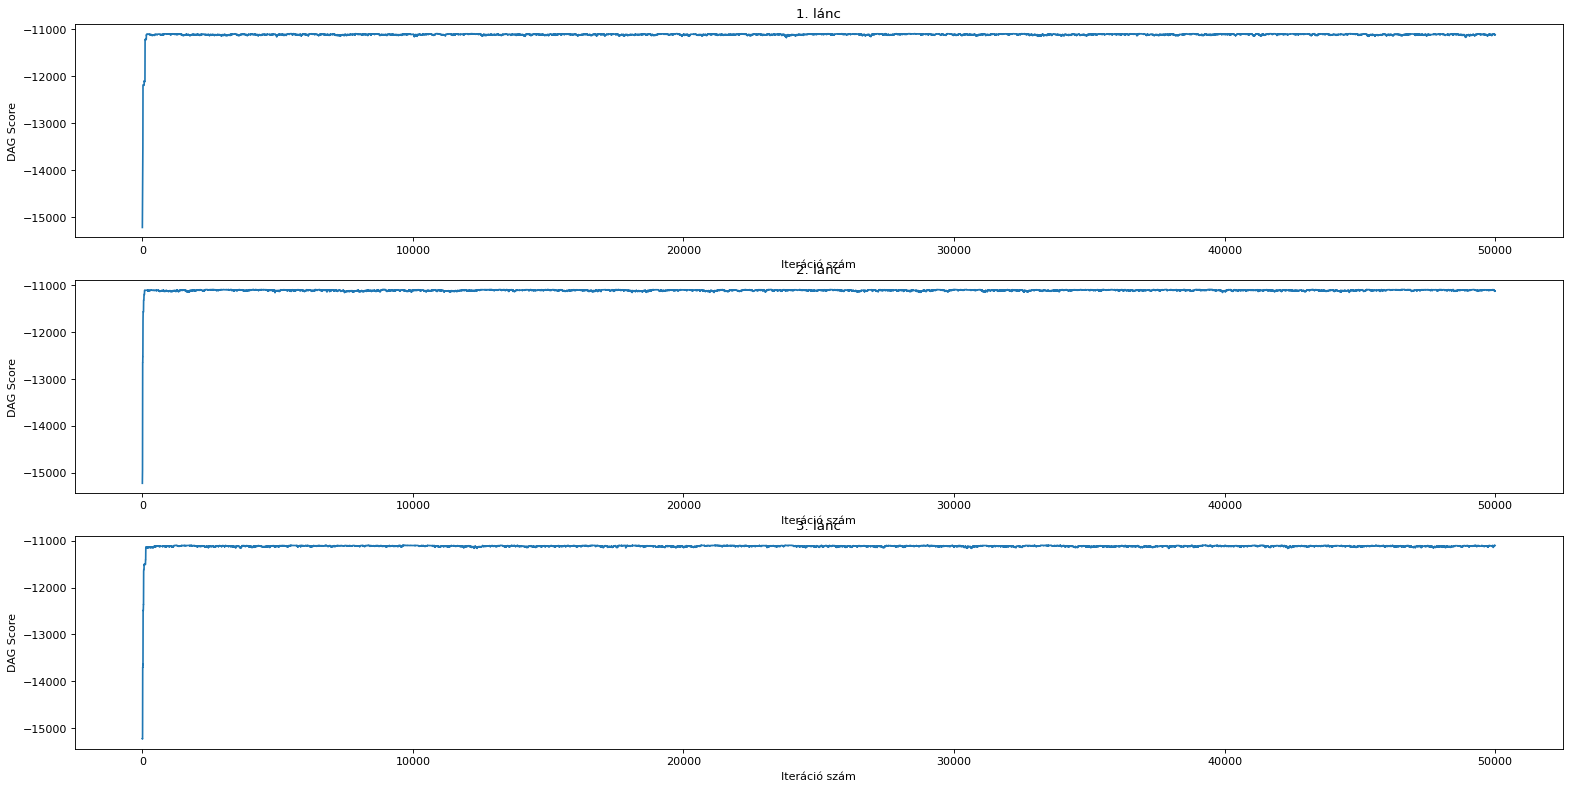

In [ ]:

fig = plt.figure(figsize=(24, 12), dpi= 80)
xVals = range(0 + 1, numIterations + 1)
for i in range(numChains):
  ax = fig.add_subplot(numChains, 1, i + 1)
  ax.set_title(f'{i+1}. lánc')
  plotted = ax.plot(xVals, dagScoresByChain[:,i])
  ax.set_xlabel('Iteráció szám')
  ax.set_ylabel('DAG Score')

plt.show()

## Legnagyobb score-t elért gráfok megjelenítése.

  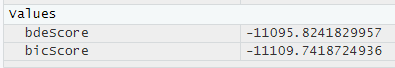

  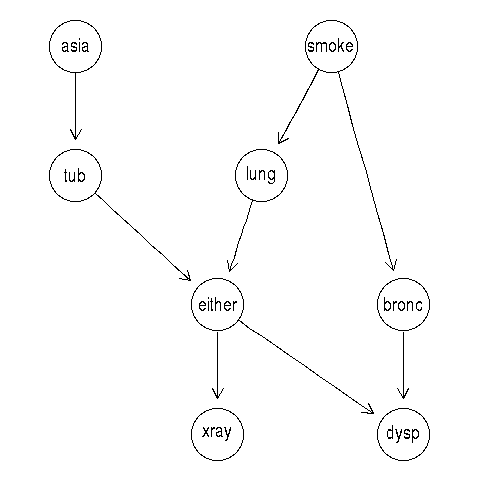

In [ ]:
array = [1,2,3,4,5]
print(array[-2])

4


1. best dag with score: -11095.788512819421


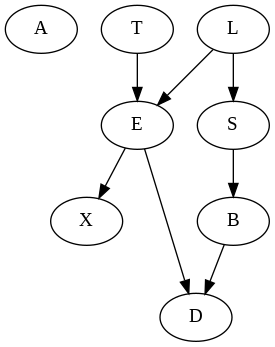

2. best dag with score: -11095.788512819423


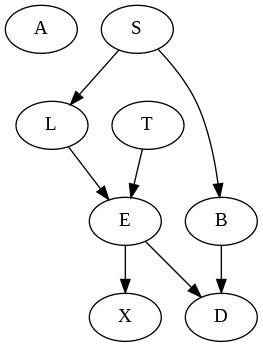

3. best dag with score: -11095.788512819427


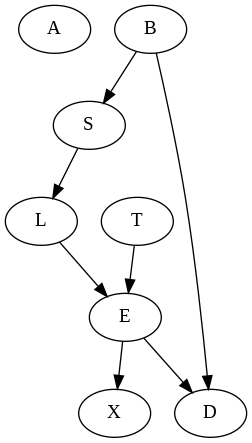

4. best dag with score: -11095.82418299562


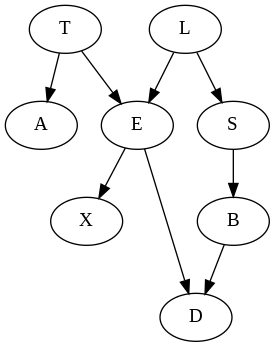

5. best dag with score: -11095.82418299562


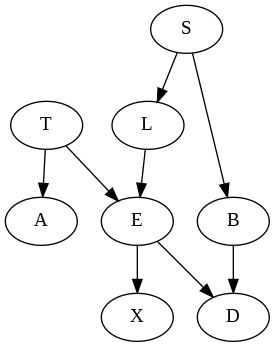

6. best dag with score: -11095.824182995622


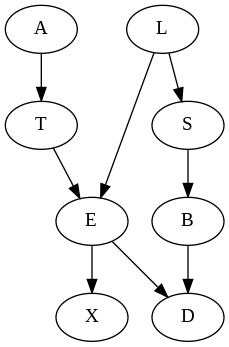

7. best dag with score: -11095.824182995624


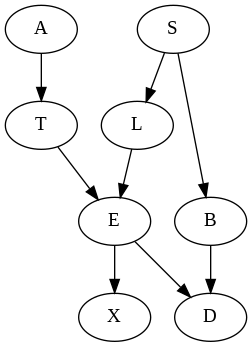

8. best dag with score: -11095.824182995624


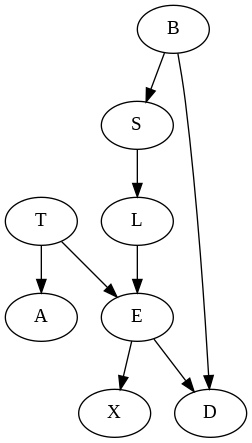

9. best dag with score: -11095.824182995628


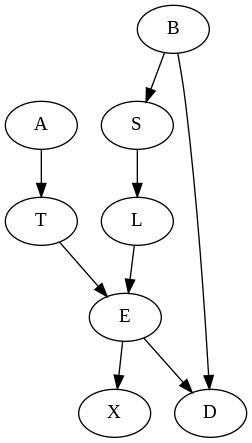

10. best dag with score: -11097.030712559163


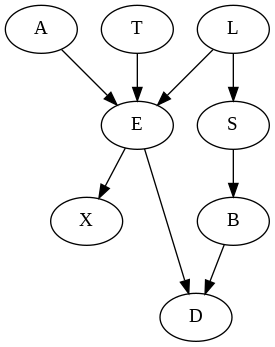

In [ ]:

dags, uniqueIndices = np.unique(np.reshape(dagsByChain, (dagsByChain.shape[0] * dagsByChain.shape[1], numNodes,numNodes)), return_index = True, axis=0)
dagScores = np.ravel(dagScoresByChain)[uniqueIndices]
sortedByScoreIndices = np.argsort(dagScores, axis = None)

dagsSortedByScore = dags[sortedByScoreIndices]
dagScoresSortedByScore = dagScores[sortedByScoreIndices]

labels = dataFrame.columns.values
for i in range(10):
  print(f'{i+1}. best dag with score: {dagScoresSortedByScore[-i-1]}')
  showDag(dagsSortedByScore[-i-1], labels)

## bnlearn segítségével tanult gráfok:


### pc.stable (default parameters)
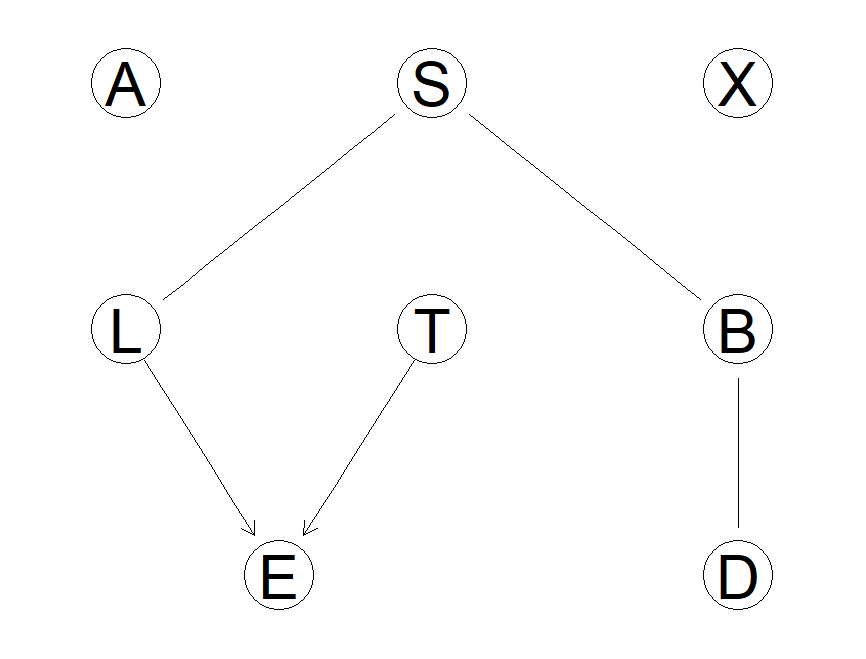

### hc hillclimbing (default parameters):

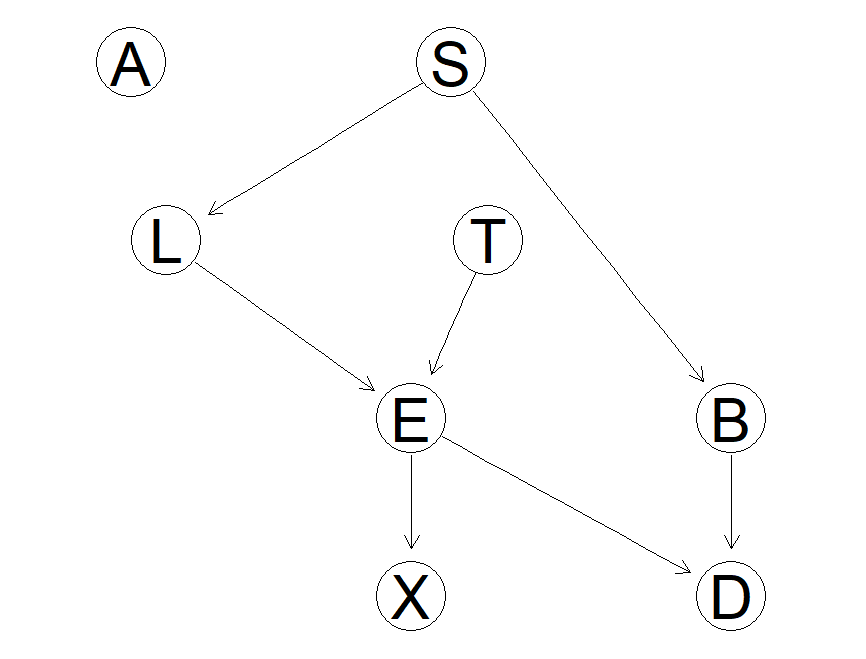

## 2d Mátrix listára él előfordulás megjelenítés

In [ ]:
from math import ceil, sqrt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
import matplotlib.patheffects as PathEffects

def showEdgeProbabilities(edgeProbabilitiesList, numMatrices, numNodes, labels, entityName = 'lánc', precision = 3, figsize = (11,11)):
  fig = plt.figure(figsize=figsize, dpi= 80)
  gridSiz = ceil(sqrt(numMatrices))
  for i in range(numMatrices):
    a = fig.add_subplot(gridSiz, gridSiz, i + 1)
    a.set_title(f'{i+1}. {entityName}')
    a.set_xticklabels([''] + labels)
    a.set_yticklabels([''] + labels)

    #ca = a.matshow(edgeProbabilitiesList[i], norm = LogNorm())
    ca = a.matshow(np.log(edgeProbabilitiesList[i]), cmap = 'hot')
    for j in range(numNodes):
      for k in range(numNodes):
          prob = edgeProbabilitiesList[i][j,k]
          txt = a.text(j, k, f'%.{precision}f' % prob, va='center', ha='center')
          txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
  fig.tight_layout(w_pad = 1)
  fig.show()

## Él előfordulások lánconként:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


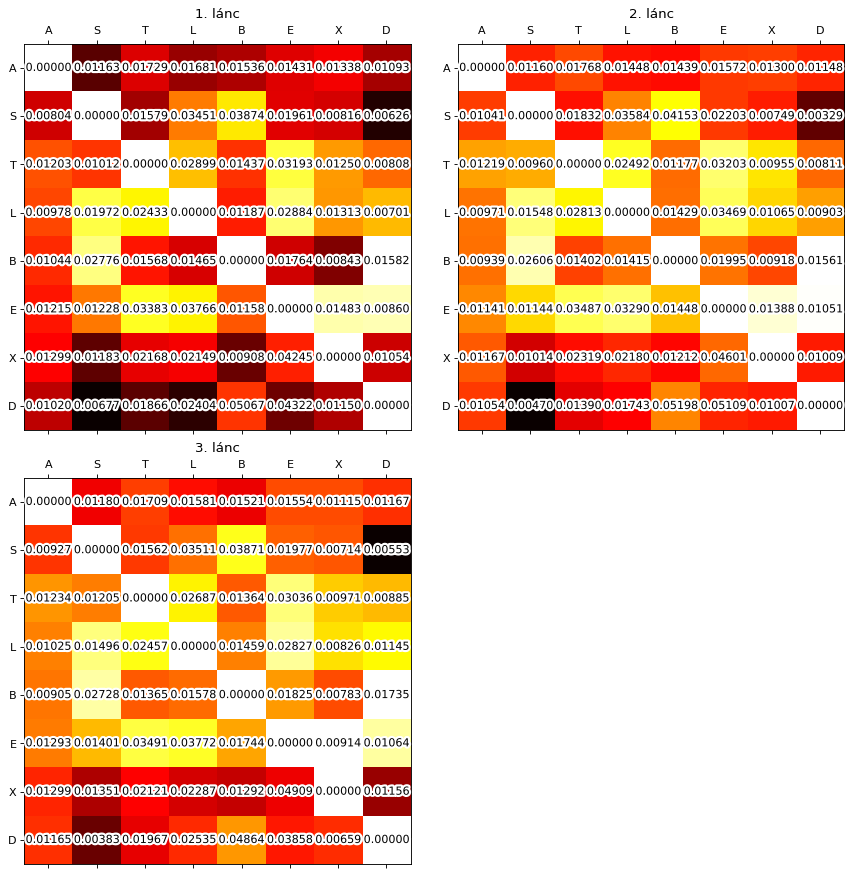

In [ ]:
# (x,y,z) (x) broadcast
edgeProbabilitiesByChain = edgeOccurencesByChain / np.expand_dims(np.sum(edgeOccurencesByChain, axis = (1,2)), axis=(1,2))

labels = list(dataFrame.columns.values)

showEdgeProbabilities(edgeProbabilitiesByChain, numChains, numNodes, labels, 'lánc', precision = 5)

## Él előfordulások láncokat aggregálva:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


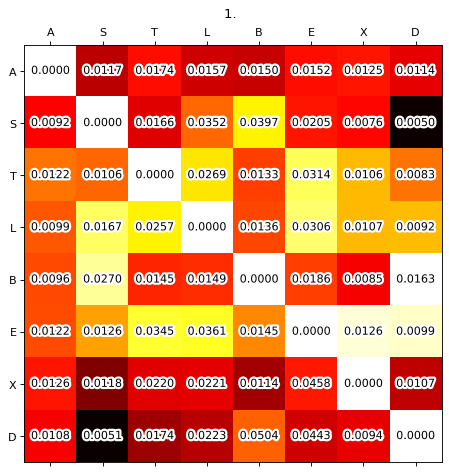

In [ ]:
edgeProbabilitiesByChain = edgeOccurencesByChain / np.expand_dims(np.sum(edgeOccurencesByChain, axis = (1,2)), axis=(1,2))

edgeProbabilities = edgeProbabilitiesByChain.sum(axis = 0)
edgeProbabilities /= edgeProbabilities.sum()
labels = list(dataFrame.columns.values)

showEdgeProbabilities([edgeProbabilities], 1, numNodes, labels, '', precision = 4, figsize = (6,6))

## Adott valószínűség küszöb feletti élek megjelenítése gráfon

In [ ]:
def plot_edgeProbability(minProb):
  pseudoIncidenceMatrix = (edgeProbabilities >= minProb).astype(int)
  showDag(pseudoIncidenceMatrix, labels)


In [ ]:
from ipywidgets import interact, interact_manual, widgets
from ipywidgets import FloatSlider, IntSlider

maxVal = np.max(edgeProbabilities)
minVal = np.min(edgeProbabilities)

secondMinVal = np.min(edgeProbabilities[edgeProbabilities > minVal])


minDiffHelpMatr = np.abs(np.reshape(edgeProbabilities, (8,8,1,1)) - np.reshape(edgeProbabilities, (1,1,8,8)))
minDiff = np.min(minDiffHelpMatr[minDiffHelpMatr > 0])
minDiff = max(1e-5, minDiff)

interact(plot_edgeProbability, minProb = FloatSlider(min=secondMinVal, max=maxVal, step=minDiff, readout_format='.4f'), continuous_update=False)

interactive(children=(FloatSlider(value=0.0050255492013106485, description='minProb', max=0.05042973804923084,…

<function __main__.plot_edgeProbability>